In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import chi2
from scipy.integrate import quad

np.random.seed(42)

In [2]:
linear_func = lambda x, m, a: m * x + a
nx = 7
x = np.linspace(-5, 9, nx)
m_true = 2.6
a_true = 0.
y_true = linear_func(x, m_true, a_true)
y_dists = []
for mu in y_true:
    # add random noise to the true values
    mu = mu + np.random.normal(1, 3)
    std = np.random.uniform(1, 2)
    sample = np.random.normal(mu, std, size=10000)
    #plt.hist(sample, bins=50, density=True)
    #plt.show()
    y_dists.append(sample)

y = np.array(y_dists)

with open('x_y.pkl', 'wb') as f:
    pickle.dump((x, y), f)

# Exercises on $\chi^2$

The file contains a set of 7 measurements for a certain variable $x$ and, for each value of $x$, 10000 measurements of a variable $y$ normally distributed.\
Run the following cell to get the measurements:

In [3]:
import pickle
with open('x_y.pkl', 'rb') as f:
    x, y = pickle.load(f)

print(x.shape)
print(y.shape)

(7,)
(7, 10000)


Perform the following tasks:

1. Compute mean and standard deviation of each distribution and plot $x$ vs $y$ with error bars on $y$
2. Using the LSM, fit the points to the function $y = mx$:\
    2.1 Define the ```chi_square``` function\
    2.2 Plot the $\chi^2$ as a function of $m$\
    2.3 Find the value of $m$ that minimizes $\chi^2$ (i.e. the best fit of $m$)\
    2.4 Compute the 1 $\sigma$ uncertainty by finding the values of $m$ for which $\chi^2 = 1$\
    2.5 Compare the values obtained with the formulae for $m$ from the weighted least squares method\
    2.6 Plot the line that represents the best fit for both cases
3. Using the LSM, fit the points to the function $y = mx + a$ by repeating the same steps of exercise 2. The only difference is that in this case there are two parameters instead of one, so the $\chi^2$ will be a paraboloid instead of a parabola.
4. Perform a goodness of fit test using the p-value as seen during the lecture

# Solutions

In [4]:
mus = y.mean(axis=1)
stds = y.std(axis=1)

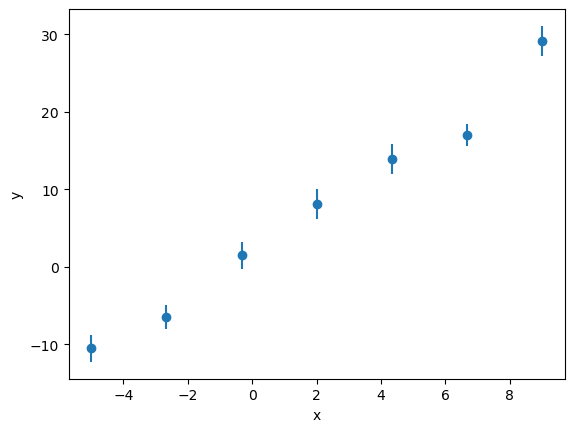

In [5]:
plt.errorbar(x, mus, yerr=stds, fmt='o');
plt.xlabel('x');
plt.ylabel('y');

First we fit $y = mx$:

m = 2.80 +0.13 -0.13


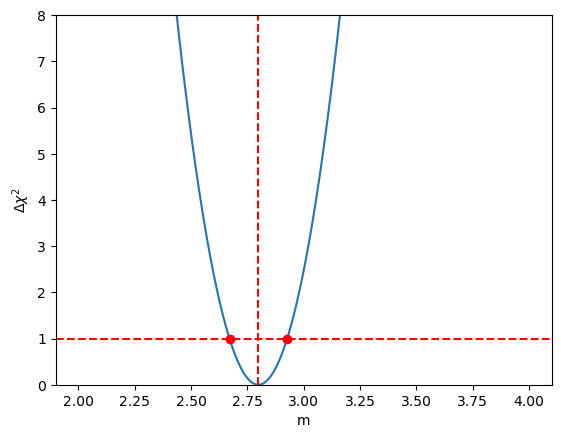

In [6]:
def chisquare(x, y, yerr, m, a):
    return np.sum(((y - linear_func(x, m, a)) / yerr) ** 2)

m_values = np.linspace(2, 4, 1000)
chi2_values_1d = np.array([chisquare(x, mus, stds, m, 0) for m in m_values])
chi2_values_1d -= chi2_values_1d.min()

# get minimum
m_best_1d = m_values[np.argmin(chi2_values_1d)]
# get 1 sigma
ml, mr = m_values[chi2_values_1d <= 1][[0, -1]]
m_left_err_1d = m_best_1d - ml
m_right_err_1d = mr - m_best_1d

# plot
plt.plot(m_values, chi2_values_1d)
plt.axvline(m_best_1d, color='red', label='m=1', linestyle='--')
plt.axhline(1, color='red', linestyle='--')
plt.plot(ml, 1, 'o', color='red')
plt.plot(mr, 1, 'o', color='red')
plt.ylim(0, 8)
plt.xlabel('m')
plt.ylabel('$\Delta\chi^2$')

print(f"m = {m_best_1d:.2f} +{m_right_err_1d:.2f} -{m_left_err_1d:.2f}")

And compare with:

$$\hat{m} = \frac{\sum w_i x_i y_i}{\sum w_i x_i^2}$$

$$\sigma_{\hat{m}} = \frac{1}{\sum w_i x_i^2}$$

where:

$$w_i = \frac{1}{\sigma_i^2}$$

In [7]:
best_m_theory_1d = np.sum(x * mus / stds**2) / np.sum(x**2 / stds**2)
sigma_m_1d = 1 / np.sqrt(np.sum(x**2 / stds**2))

print(f"a = {best_m_theory_1d:.2f} +/- {sigma_m_1d:.2f}")

a = 2.80 +/- 0.13


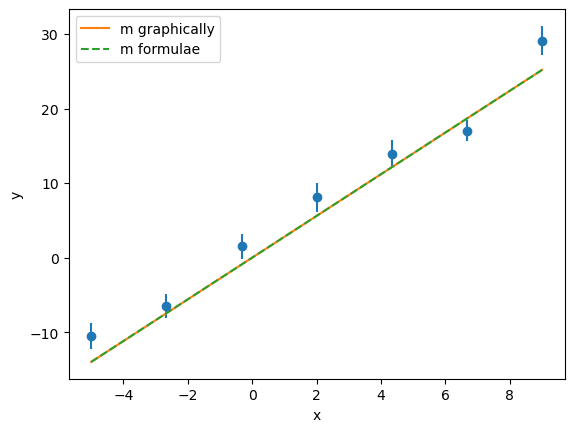

In [18]:
plt.errorbar(x, mus, yerr=stds, fmt='o');
plt.plot(x, linear_func(x, m_best_1d, 0), label='m graphically');
plt.plot(x, linear_func(x, best_m_theory_1d, 0), label='m formulae', linestyle='--');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

p-value = 0.88


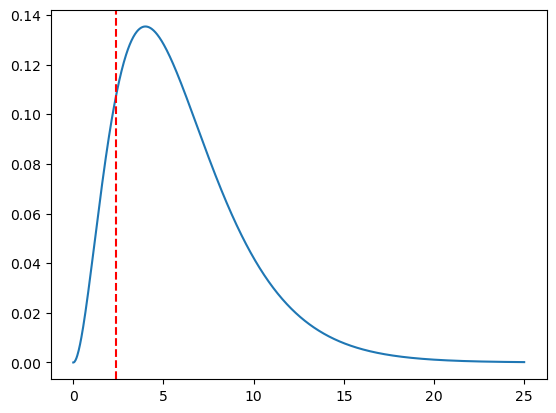

In [9]:
chi_best_1d = chisquare(x, mus, stds, m_best_1d, 0)
dof = len(x) - 1
frozen = chi2(df=dof)
x_chi = np.linspace(0, 25, 1000)
# integrate the chi2 distribution from chi_best to infinity
pval = quad(frozen.pdf, chi_best_1d/dof, np.inf)[0]

plt.plot(x_chi, frozen.pdf(x_chi));
plt.axvline(chi_best_1d / dof, color='red', linestyle='--');

print(f"p-value = {pval:.2f}")

Then we fit $y = mx + a$:

m = 2.66 +0.19 -0.19
a = 1.83 +0.98 -0.98


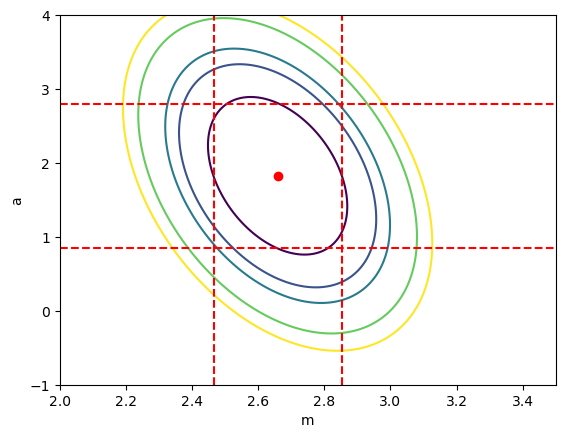

In [13]:
# define the grid of m and a values
m_values = np.linspace(2, 3.5, 1000)
a_values = np.linspace(-1, 4, 1000)

chi2_values = np.vstack([np.array([chisquare(x, mus, stds, m, a) for m in m_values]) for a in a_values])
chi2_values -= chi2_values.min()
a_min_index, m_min_index = np.unravel_index(np.argmin(chi2_values), chi2_values.shape)
m_best_2d = m_values[m_min_index]
a_best_2d = a_values[a_min_index]
# find 1 sigma uncertainties
mdown = m_values[np.where(chi2_values[a_min_index] <= 2.3)[0][0]]
mup = m_values[np.where(chi2_values[a_min_index] <= 2.3)[0][-1]]
m_down_err_2d = m_best_2d - mdown
m_up_err_2d = mup - m_best_2d
adown = a_values[np.where(chi2_values[:, m_min_index] <= 2.3)[0][0]]
aup = a_values[np.where(chi2_values[:, m_min_index] <= 2.3)[0][-1]]
a_down_err_2d = a_best_2d - adown
a_up_err_2d = aup - a_best_2d

# plot
plt.contour(m_values, a_values, chi2_values, levels=[2.3, 4.61, 5.99, 9.21, 11.34]);
# plt best
plt.plot(m_best_2d, a_best_2d, 'o', color='red');
plt.xlabel('m');
plt.ylabel('a');
# plot horizontal and vertical lines for 1 sigma
plt.axvline(mdown, color='red', linestyle='--');
plt.axvline(mup, color='red', linestyle='--');
plt.axhline(adown, color='red', linestyle='--');
plt.axhline(aup, color='red', linestyle='--');

print(f"m = {m_best_2d:.2f} +{m_up_err_2d:.2f} -{m_down_err_2d:.2f}")
print(f"a = {a_best_2d:.2f} +{a_up_err_2d:.2f} -{a_down_err_2d:.2f}")

And compare with:

$$\hat{a} = \frac{\sum wx^2 \sum wy - \sum wx \sum wxy}{\Delta}$$

$$\hat{m} = \frac{\sum w \sum wxy - \sum wx \sum wy}{\Delta}$$

$$\sigma_a = \sqrt{\frac{\sum w x^2}{\Delta}}$$

$$\sigma_m = \sqrt{\frac{\sum w}{\Delta}}$$

where

$$\Delta = \sum w \sum wx^2 - (\sum w x)^2$$

In [14]:
# formulae for m and error from theory
delta = np.sum(1 / stds ** 2) * np.sum(x ** 2 / stds ** 2) - np.sum(x / stds ** 2) ** 2

best_a_theory = (np.sum(x ** 2 / stds ** 2) * np.sum(mus / stds ** 2) - np.sum(x / stds ** 2) * np.sum(x * mus / stds ** 2)) / delta
best_m_theory = (np.sum(1 / stds ** 2) * np.sum(x * mus / stds ** 2) - np.sum(x / stds ** 2) * np.sum(mus / stds ** 2)) / delta

sigma_a_theory = np.sqrt(np.sum(x ** 2 / stds ** 2) / delta)
sigma_b_theory = np.sqrt(np.sum(1 / stds ** 2) / delta)

print('m = {:.2f} + {:.2f} - {:.2f}'.format(best_m_theory, sigma_b_theory, sigma_b_theory))
print('a = {:.2f} + {:.2f} - {:.2f}'.format(best_a_theory, sigma_a_theory, sigma_a_theory))

m = 2.66 + 0.14 - 0.14
a = 1.83 + 0.70 - 0.70


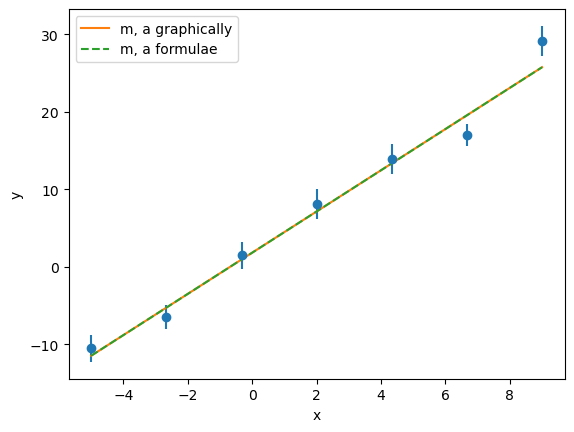

In [19]:
plt.errorbar(x, mus, yerr=stds, fmt='o');
plt.plot(x, linear_func(x, m_best_2d, a_best_2d), label='m, a graphically');
plt.plot(x, linear_func(x, best_m_theory, best_a_theory), label='m, a formulae', linestyle='--');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

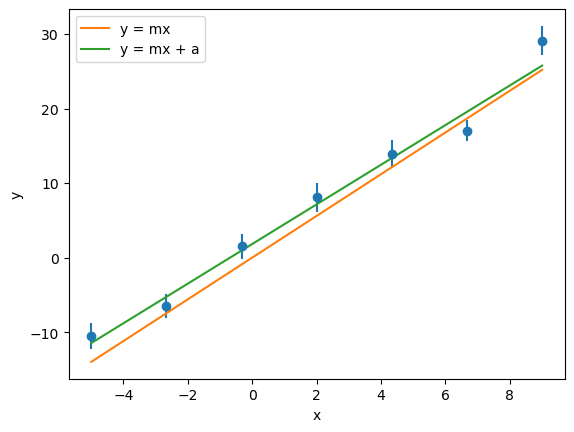

In [20]:
plt.errorbar(x, mus, yerr=stds, fmt='o');
plt.plot(x, linear_func(x, m_best_1d, 0), label='y = mx');
plt.plot(x, linear_func(x, m_best_2d, a_best_2d), label='y = mx + a');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

p-value = 0.91


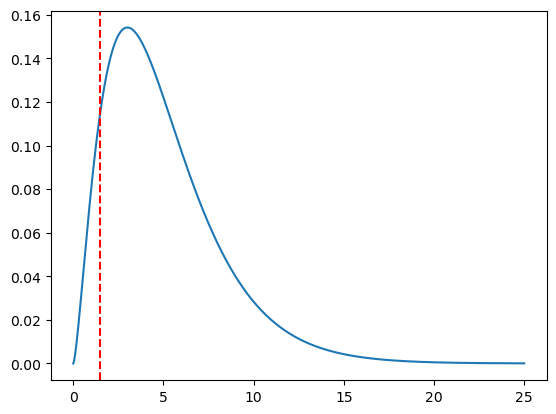

In [17]:
chi_best_2d = chisquare(x, mus, stds, m_best_2d, a_best_2d)
dof = len(x) - 2
frozen = chi2(df=dof)
x_chi = np.linspace(0, 25, 1000)
# integrate the chi2 distribution from chi_best to infinity
pval = quad(frozen.pdf, chi_best_2d/dof, np.inf)[0]

plt.plot(x_chi, frozen.pdf(x_chi));
plt.axvline(chi_best_2d/dof, color='red', linestyle='--');

print(f"p-value = {pval:.2f}")